In [6]:
# ------ River imports ---------

from river import stream

# Metrics
from river.metrics import Accuracy, Precision, Recall, F1, CohenKappa, BalancedAccuracy

# Drift Detectors
from river.drift import ADWIN, KSWIN, PageHinkley, DriftRetrainingClassifier
from river.drift.binary import *

# Classifiers
from river.linear_model import LogisticRegression
from river.forest import ARFClassifier
from river.tree import HoeffdingTreeClassifier, ExtremelyFastDecisionTreeClassifier

In [7]:
# ------ Sk-learn imports -------------

# sklearn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Others
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [5]:
# ------ Basic python lib imports ----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import mplcursors

In [8]:
# ------ Get "cfpdss" data --------------------------
df_cfpdss = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss.csv"
)
df_cfpdss.head()

,c5,c6,c7,c8,c9,n0,n1,n2,n3,n4,class
0,a,a,b,a,a,0.448573,1.212644,2.555515,0.242702,0.697604,A
1,a,a,a,b,b,1.902515,-0.467349,-0.744523,-0.017156,-0.380288,A
2,a,a,a,b,b,0.825045,1.002267,1.972207,-0.790095,0.233456,B
3,a,a,a,b,b,-0.124974,0.902601,1.696092,-0.320182,0.243261,A
4,b,a,a,b,a,-1.259765,0.793134,1.547527,-2.132172,-0.788367,B


In [9]:
# ------ Data pre-processing --------------
X_df = df_cfpdss.drop(columns="class")

# Separating categorical and non-categorical columns
categorical_columns = X_df.select_dtypes(include=["object"]).columns.tolist()
X_df_categorical = X_df[categorical_columns]
non_cat_columns = [col for col in X_df.columns if col not in categorical_columns]
X_df_non_categorical = X_df[non_cat_columns]

# One hot encoding - Categorical data
encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
one_hot_encoded = encoder.fit_transform(X_df_categorical)
columns = encoder.get_feature_names_out()
X_df_cat_one_hot = pd.DataFrame(one_hot_encoded, columns=columns)

# Feature scaling numerical data/non-categorical data
scaler = MinMaxScaler()
X_non_cat_df = pd.DataFrame(
    scaler.fit_transform(X_df_non_categorical), columns=scaler.get_feature_names_out()
)

# Concatenate categorical and non-categorical data
X_df_encoded = pd.concat(
    [
        X_df_cat_one_hot,
        X_non_cat_df,
    ],
    axis=1,
)

# Encoding the target variable
y_df = df_cfpdss[["class"]]
y_encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
y_one_hot = y_encoder.fit_transform(y_df)
y_encoded = pd.Series(y_one_hot.ravel())

In [19]:
# ------ Function to detect concept drift --------
def detect_concept_drift(model, X_df, y_df, metric, drift_detector):
    i = 0  # timepoints
    metric_score_list = []  # record the real-time metric
    concept_drifts_timepoints = []
    my_model = model
    my_drift_detector = drift_detector

    # Stream data updating the metric and checking for drifts
    for xi, yi in stream.iter_pandas(X_df, y_df):
        y_pred = my_model.predict_one(xi)
        my_model.learn_one(xi, yi)
        metric.update(yi, y_pred)
        my_drift_detector.update(metric.get())
        metric_score_list.append(metric.get() * 100)

        if my_drift_detector.drift_detected:
            concept_drifts_timepoints.append(i)
            my_model = model
            # my_drift_detector._reset()

        i = i + 1
    return concept_drifts_timepoints, metric_score_list

In [29]:
# ------ Function to plot concept drift -------------
def plot_concept_drift(
    concept_drifts_timepoints,
    metric_score_list,
    name: "Model Name + Drift Detector + Metric",
):
    plt.rcParams.update({"font.size": 15})
    plt.figure(1, figsize=(10, 6))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(
        list(range(len(metric_score_list))),
        metric_score_list,
        "-b",
        label="Avg Metric Score: %.2f%%" % (metric_score_list[-1]),
    )

    plt.legend(loc="best")
    plt.title(name + " on cfpdss dataset", fontsize=15)
    plt.xlabel("Timepoint")
    plt.ylabel("Metric Score")

    # Plot concept drift with vertical lines
    for i in range(len(concept_drifts_timepoints)):
        # plt.text(self.concept_drifts_timepoints[i] - 500, 100.8, 'Drift ' + str(i), c="red", fontsize=25)
        plt.vlines(
            concept_drifts_timepoints[i],
            0,
            100,
            colors="red",
            linewidth=2,
            linestyles="dashed",
        )
    mplcursors.cursor(hover=True)

    plt.show()

In [33]:
# ------ Config for model, metric and drift detector ---------
models_dict = {
    # "Hoeffding Tree Classifier" : HoeffdingTreeClassifier(),
    # "Extremely Fast DTs" : ExtremelyFastDecisionTreeClassifier(),
    "Logistic Regresion": LogisticRegression(),
}

metrics_dict = {
    "Accuracy": Accuracy(),
    "F1": F1(),
    "Kappa": CohenKappa(),
}

drift_detectors_dict = {
    "ADWIN": ADWIN(delta=0.05),
    "DDM": DDM(),
    # "KSWIN" : KSWIN(),
    # "Page Hinkley" : PageHinkley()
}

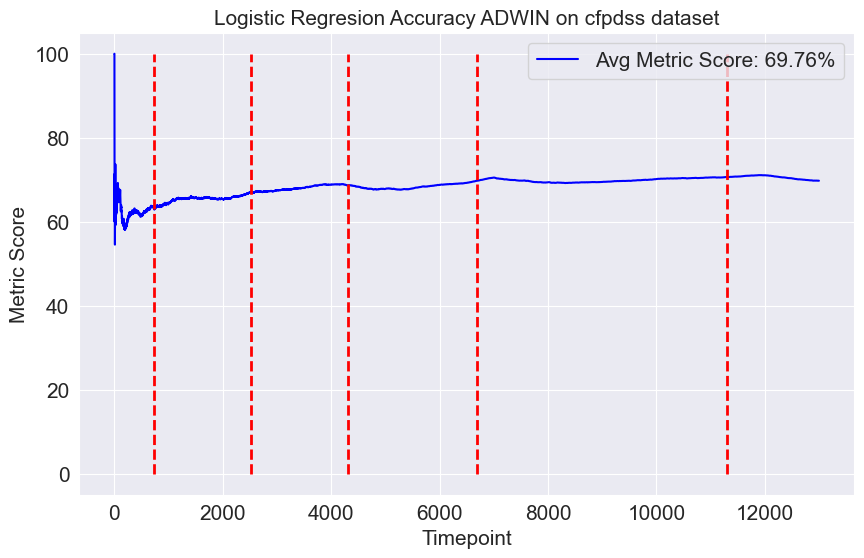

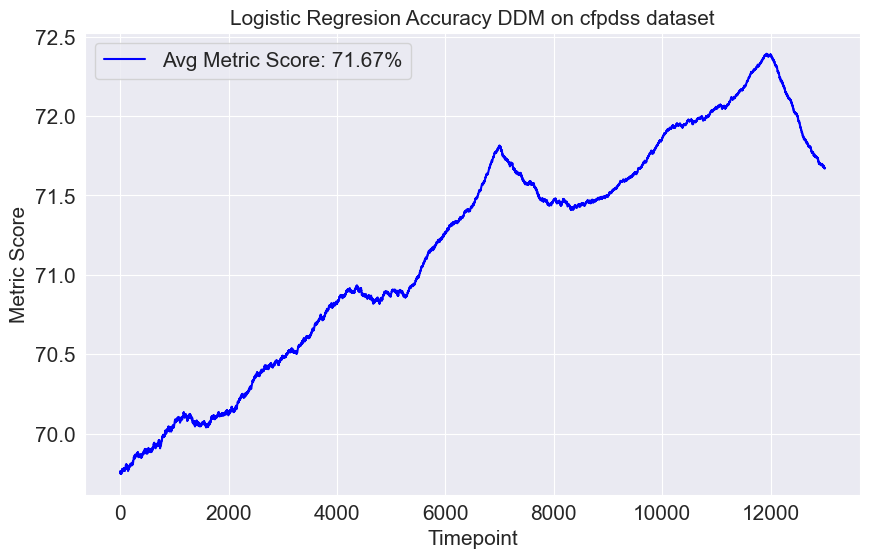

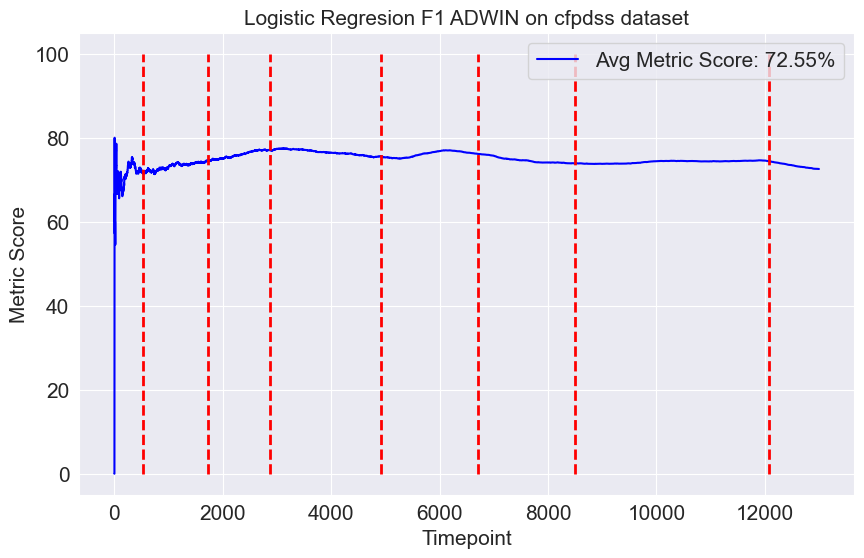

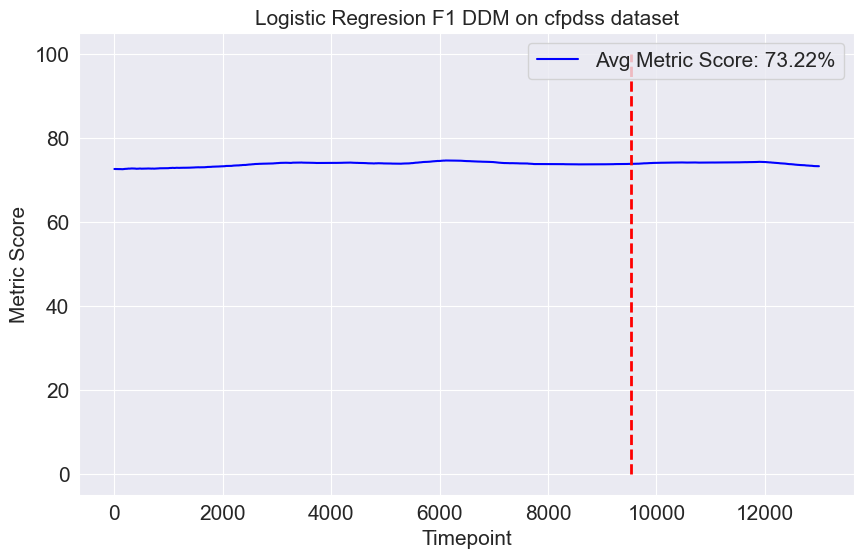

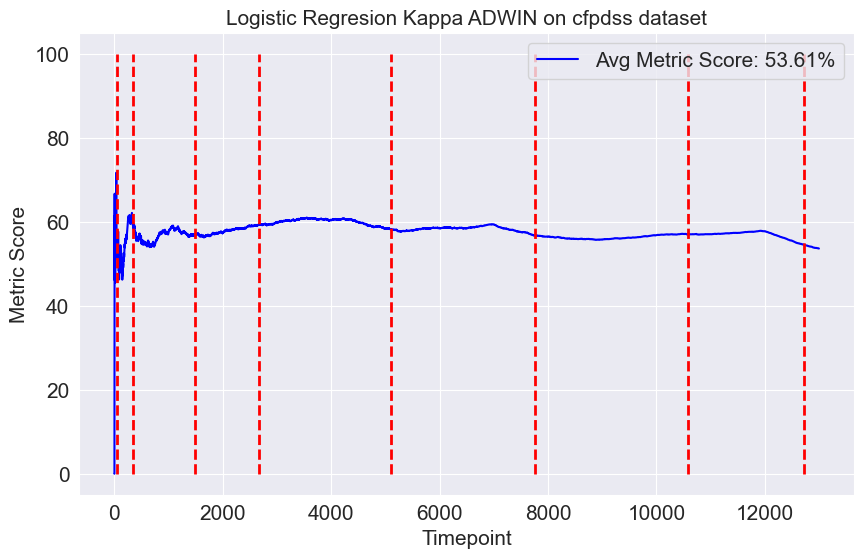

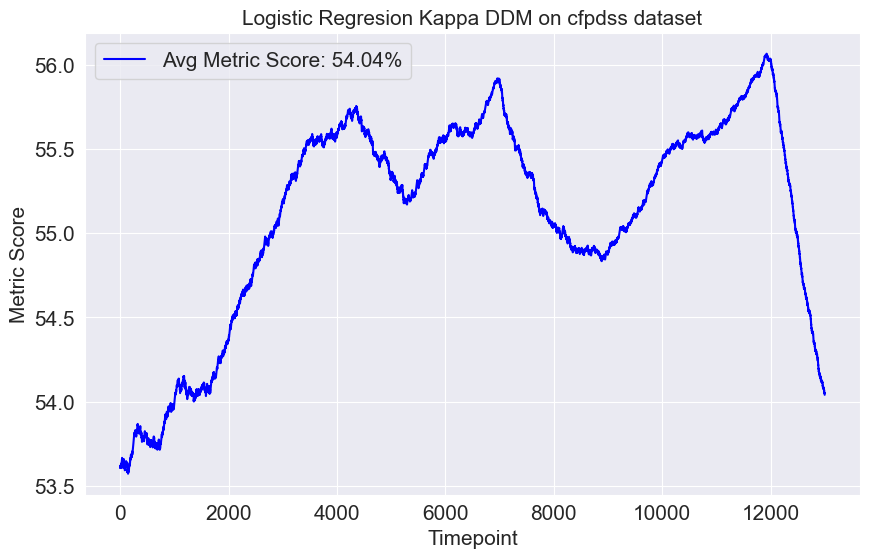

In [34]:
# ----- Plot for all combination for model, metric and drift detector -----
for model_name, model in models_dict.items():
    for metric_name, metric in metrics_dict.items():
        for drift_detector_name, drift_detector in drift_detectors_dict.items():
            concept_drift_timepoints, metric_score_list = detect_concept_drift(
                model, X_df_encoded, y_encoded, metric, drift_detector
            )
            plot_concept_drift(
                concept_drift_timepoints,
                metric_score_list,
                model_name + " " + metric_name + " " + drift_detector_name,
            )